In [1]:
import pandas as pd
import numpy as np #vektorler uzerinde islem yapmak icin

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, f1_score, precision_score,recall_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

import pydot
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC
from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter

from tensorflow.keras import preprocessing

from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential


from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn import metrics #accuracy 
from sklearn.multiclass import OneVsRestClassifier
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("preprocessed_tweetVaccine.csv")
train_df.head()

,Unnamed: 0,text,Subjectivity,Polarity,Analysis
0,0,australia manufacture covid19 vaccine and give...,0.4000,0.4000,Positive
1,1,coronavirusvaccine coronavaccine covidvaccine ...,0.9100,0.9100,Positive
2,2,deaths due covid19 affected countries read mor...,0.1875,0.1875,Positive
3,3,teamsubhashree subhashreesotwe iamrajchoco sta...,0.5000,0.5000,Positive
4,4,michellegrattan conversationedu this what pass...,0.0000,0.0000,Neutral


In [3]:
train_df['word_counter'] = train_df['text'].apply(lambda x:len(str(x).split()))

In [4]:
print('Training data:')
print(train_df['Analysis'].value_counts())
print('toplam text:', len(train_df))

max_train_sentence_length = train_df['word_counter'].max()

Training data:
Positive    9711
Neutral     9511
Negative    2717
Name: Analysis, dtype: int64
toplam text: 21939


In [5]:
tokenizer = Tokenizer(num_words = 20000, oov_token="<UKN>")
tokenizer.fit_on_texts(train_df['text'].values.astype(str).tolist()) #metin listesine dayalı olarak dahili kelimeleri günceller

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['Analysis'], test_size=0.3,random_state=1)

In [10]:
x_train = np.array(tokenizer.texts_to_sequences(X_train.values.astype(str)))
x_test = np.array(tokenizer.texts_to_sequences(X_test.values.astype(str))) #Metinlerdeki her metni bir tam sayı dizisine dönüştürür

In [11]:
x_train = pad_sequences(x_train, padding='post',maxlen=250)
x_test = pad_sequences(x_test, padding='post',maxlen=250)

leb = LabelEncoder()
train_label = leb.fit_transform(y_train)
train_label = np.array(tf.keras.utils.to_categorical(train_label))

test_label = leb.fit_transform(y_test)
test_label = np.array(tf.keras.utils.to_categorical(test_label))

#list(leb.classes_)

In [12]:

from keras.layers import Activation, Flatten
max_features = 25000
embedding_dim = 60
sequence_length = 250
 
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, \
                                    input_length=sequence_length, embeddings_regularizer = regularizers.l2(0.005)))

model.add(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,\
                                   kernel_regularizer = regularizers.l2(0.005), bias_regularizer=regularizers.l2(0.005)))
                                   

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(250, activation='relu',kernel_regularizer = regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer = regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(3, activation='softmax',kernel_regularizer = regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['CategoricalAccuracy', AUC(name='auc')])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 60)           1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 250, 60)           29040     
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               3750250   
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
__________________

In [13]:
epochs = 10

history = model.fit(x_train, train_label, epochs = epochs, validation_data = (x_test, test_label), verbose = 2)

Train on 15357 samples, validate on 6582 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
15357/15357 - 90s - loss: 1.4774 - categorical_accuracy: 0.6281 - auc: 0.8076 - val_loss: 0.9696 - val_categorical_accuracy: 0.7908 - val_auc: 0.9089
Epoch 2/10
15357/15357 - 88s - loss: 0.9131 - categorical_accuracy: 0.7931 - auc: 0.9112 - val_loss: 0.8323 - val_categorical_accuracy: 0.8072 - val_auc: 0.9274
Epoch 3/10
15357/15357 - 88s - loss: 0.7928 - categorical_accuracy: 0.8185 - auc: 0.9295 - val_loss: 0.7032 - val_categorical_accuracy: 0.8339 - val_auc: 0.9419
Epoch 4/10
15357/15357 - 87s - loss: 0.6962 - categorical_accuracy: 0.8315 - auc: 0.9431 - val_loss: 0.6716 - val_categorical_accuracy: 0.8367 - val_auc: 0.9476
Epoch 5/10
15357/15357 - 87s - loss: 0.6558 - categorical_accuracy: 0.8382 - auc: 0.9490 - val_loss: 0.6801 - val_categorical_accuracy: 0.8421 - val_auc: 0.9444
Epoch 6/10
15357/15357 - 88s - loss: 0.6354 - catego

In [11]:
epochs = 7

history = model.fit(x_train, train_label, epochs = epochs, validation_data = (x_test, test_label), verbose = 1)

Train on 17551 samples, validate on 4388 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
17551/17551 [==============================] - 103s 6ms/sample - loss: 1.4314 - categorical_accuracy: 0.4369 - auc: 0.6542 - val_loss: 1.0831 - val_categorical_accuracy: 0.4387 - val_auc: 0.6500
Epoch 2/10
17551/17551 [==============================] - 103s 6ms/sample - loss: 1.0359 - categorical_accuracy: 0.4362 - auc: 0.6573 - val_loss: 1.0069 - val_categorical_accuracy: 0.4328 - val_auc: 0.6563
Epoch 3/10
17551/17551 [==============================] - 107s 6ms/sample - loss: 0.9927 - categorical_accuracy: 0.4399 - auc: 0.6584 - val_loss: 0.9916 - val_categorical_accuracy: 0.4328 - val_auc: 0.6521
Epoch 4/10
17551/17551 [==============================] - 107s 6ms/sample - loss: 0.9852 - categorical_accuracy: 0.4432 - auc: 0.6566 - val_loss: 0.9899 - val_categorical_accuracy: 0.4328 - val_auc: 0.6521
Epoch 5/10
17551/17551 [=========

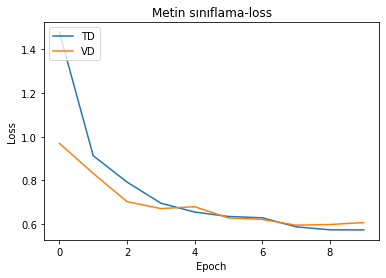

In [14]:
plt.plot(history.history['loss'], label = 'TD')
plt.plot(history.history['val_loss'], label = 'VD')
plt.title('Metin sınıflama-loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

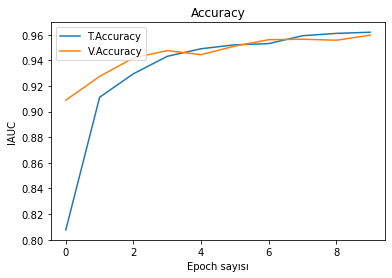

In [15]:
plt.plot(history.history['auc'], label = 'T.Accuracy')
plt.plot(history.history['val_auc'], label = 'V.Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch sayısı')
plt.ylabel('AUC')
plt.legend(loc='upper left')
plt.show()